# library

In [1]:
# from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import calibration_curve
from sklearn.metrics import roc_curve,recall_score, confusion_matrix, accuracy_score, precision_score, f1_score
from sklearn.metrics import roc_auc_score
import xgboost as xgb
import json
import pickle
import csv


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import seaborn as sns

pd.options.display.max_columns = 100
pd.options.display.max_rows = 100
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.family'] = 'Yu mincho'

import os
import gc
import sys
import glob
# import tqdm
import pickle
import json
import pathlib
import datetime
import configparser
import warnings
warnings.simplefilter('ignore')

In [2]:
from plot_helper import *
from read_df import df_from_csv
import balance_target
import scale_feature

# config

In [3]:
TARGET_VALUE = 3
FILL_VALUE = -2
num_round = 200
params = {
        'objective': 'binary:logistic',
        'silent':0,
        'gamma':10,
        'random_state':0,
        # 学習用の指標 (RMSE)
        'eval_metric': 'logloss',
}

key_cols = ['race_id', 'horse_id', 'race_date', 'arrival']
not_z_col = [
    'weight_null_flg',
    'is_same_place',
    'same_cluster_flg',
    'gender_セ',
    'gender_牝',
    'gender_牡',
    'place_なし',
    'place_地',
#     'place_外',
    'place_東',
    'place_西',
    'first_data_flg',
    'is_first_in_prize',
    'last_turf_flg',
    'last_weather_int',
    'last_condition_int',
    'course_num',
    'race_month',
    'age',
    'last_got_prize_sum_rank',
    'abs_weight_change_rate',
    'abs_weight_change_rate_rank',
    'interval_days_diff',
    'last_uphill_rank',
    'race_class_prize_1勝クラス',
    'race_class_prize_2勝クラス',
    'race_class_prize_3勝クラス', 
    'race_class_prize_未勝利'
]

## 標準化
ss_col = [
    'weight',
    'weight_change_rate',
    'handy_rate',
    'handy_weight',
    'age_ss',
    'interval_days',
    'abs_distance_diff',
    'last_speed',
    'last_uphill_speed',
    'last_uphill',
    'last_uphill_samecc',
    'last_weight_3_mean',
    'abs_weight_change',
    'last_got_prize',
    'last_got_prize_sum',
    'm_rate',
]

mm_col = [
    'last_arrival',
    'p2_arrival',
    'p3_arrival',
]

# X_cols = ss_col + mm_col + not_z_col
# print('len(X_cols): ', len(X_cols))
# dt_now = datetime.datetime.now().strftime('%Y%m%d%H%M')

# log_path = resource_path /'model_build/logs/wh' /dt_now
# os.makedirs(log_path/'image', exist_ok=True)



# method

In [4]:

def split_data(df_use):
    ## モデル
    valid_id = np.random.choice(df_use.race_id.unique(), size=int(df_use.race_id.nunique() * 0.1), replace=False)
    print('valid_id len: ',len(valid_id))

    df_test = df_use.query('race_id in @valid_id')
    print('df_test:  shape/race_id num', df_test.shape, df_test.race_id.nunique())
    df_train = df_use.query('race_id not in @valid_id')
    print('df_train: shape/race_id num', df_train.shape, df_train.race_id.nunique())

    target_size = df_train.target.sum()
    df_train_0 = df_train[df_train.target==0]
    df_train_use = df_train_0.sample(target_size, random_state=0)
    df_train_use = pd.concat([df_train_use, df_train[df_train.target==1]])

    df_sampling = balance_target.get_df_sampling(df_train_use['target'], df_test['target'], 'target')
    df_sampling.loc['test', 'num_id'] = len(valid_id)
    df_sampling.loc['All', 'num_id'] = df_use.race_id.nunique()
    df_sampling.to_csv(log_path/'data_num.csv', encoding='utf-8-sig')
    return df_train_use, df_test


def build_model(df_train):
    X_train = df_train[X_cols]
    y_train = df_train['target']
    dtrain = xgb.DMatrix(X_train, label=y_train)
    # dvalid = xgb.DMatrix(X_test, label=y_test)
    # watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
    model = xgb.train(
        params,
        dtrain,#訓練データ
        num_round,#設定した学習回数
        # early_stopping_rounds=20,
        # evals=watchlist,
    )
    return model


def output_model(model, y_test, prob2, s_rate):
    pickle.dump(model,open(log_path/'model.pickle', 'wb'))
#     model.trees_to_dataframe().to_csv(log_path/'model_trees.csv', encoding='utf-8-sig', index=False)
    pd.DataFrame([model.feature_importances_], columns=X_cols).T.to_csv(log_path/'feature_importances.csv', encoding='utf-8-sig', index=False)

    xgb.plot_importance(
        model,
    #     cls_rdn.best_estimator_,
        importance_type='gain',
        show_values=False,
        max_num_features=40
    )
    plt.savefig(log_path/'image/feature_importance.png', pad_inches=.05, bbox_inches='tight')

    get_score_plot(get_scores(y_test, prob2), log_path/'image/score_by_th.png')
    plot_calibration(y_test, prob2, log_path/'image/calibration_plot.png')
    plot_roc(y_test, prob2, log_path/'image/roc_plot.png')
    with open(log_path/'model_config.json', 'w') as f:
        json.dump({
                'ss_col': ss_col, 
                'mm_col': mm_col,
                'not_z_col':not_z_col,
                'X_cols': X_cols,
                'TARGET_VALUE': TARGET_VALUE,
                'FILL_VALUE': FILL_VALUE,
                'params': model.get_params(),
#                 'num_round': num_round,
                's_rate': s_rate
            },
            f,
            indent=4
        )
    with open(log_path/'AUC.csv', 'a') as f:
        writer = csv.writer(f, lineterminator='\n') # 行末は改行
        writer.writerow([dt_now, roc_auc_score(y_test, prob2), TARGET_VALUE, COMMENT])


def predict(model, s_rate, df_test, df_use):
#     dtest = xgb.DMatrix(df_test[X_cols])
    prob2 = balance_target.adjusted_prob(model.predict_proba(df_test[X_cols])[:, 1], s_rate)
    df_test['pred_prob'] = prob2
    df_test[['arrival', 'horse_id', 'race_id', 'pred_prob']].to_csv(log_path/f'score.csv', index=False)

    prob3 = balance_target.adjusted_prob(model.predict_proba(df_use[X_cols])[:, 1], s_rate)
    df_use['pred_prob'] = prob3
    df_use[['arrival', 'horse_id', 'race_id', 'pred_prob']].to_csv(log_path/f'score_all.csv', index=False)
    return prob2
 

def main(filename):
    file_input = resource_path/f'model_build/features/WinHorse_all_{filename}.csv'
    df_main = df_from_csv(file_input)
    df_main.race_date = pd.to_datetime(df_main.race_date)
    df_main['race_month'] = df_main.race_date.dt.month
    df_use = scale_feature.scale_by_race_id(df_main, ss_col, mm_col, key_cols+not_z_col)
    df_use['target'] = 0
    df_use.loc[df_use.arrival<=TARGET_VALUE, 'target'] = 1
    
    df_use.fillna(FILL_VALUE, inplace=True)
    df_train, df_test = split_data(df_use)
    y_test = df_test['target']
    
    s_rate = balance_target.get_srate(y_test)
    model = build_model(df_train)
    prob2 = predict(model, s_rate, df_test, df_use)
    AUC = roc_auc_score(y_test, prob2)
    print('AUC: ', AUC)
#     print('出力フォルダ: ', log_path)
#     output_model(model, y_test, prob2, s_rate, AUC)

# read data

## features

In [36]:
filename = 'new'
file_input = resource_path/f'model_build/features/WinHorse_all_{filename}.csv'
df_main = df_from_csv(file_input)
df_main.race_date = pd.to_datetime(df_main.race_date)
df_main['race_month'] = df_main.race_date.dt.month.astype(str)
df_main.head(2)

,arrival,race_id,horse_id,race_date,age,first_data_flg,last_weight_3_mean,interval_days,last_turf_flg,distance_diff,last_weather_int,last_condition_int,is_first_in_prize,last_arrival,p2_arrival,p3_arrival,last_speed,last_uphill,last_uphill_speed,last_uphill_samecc,same_cluster_flg,is_same_place,last_got_prize,last_got_prize_sum,course_num,weight,abs_weight_change,weight_null_flg,weight_change_rate,handy_weight,handy_rate,abs_distance_diff,last_got_prize_sum.1,last_got_prize_sum_rank,abs_weight_change_rate,abs_weight_change_rate_rank,last_uphill_rank,interval_days_diff,interval_days_diff_rank,m_rate,gender_セ,gender_牝,gender_牡,place_なし,place_地,place_外,place_東,place_西,race_class_prize_1勝クラス,race_class_prize_2勝クラス,race_class_prize_3勝クラス,race_class_prize_未勝利,race_month
0,2,201209030106,5301,2012-06-02,3,0,NaN,28.0,1,0.0,1.0,2.0,0,2.0,NaN,NaN,250.0,36.0,0.1440,NaN,0,1,200.0,480.0,9,430.0,8.0,0,NaN,54.0,0.125581,0.0,480.0,1.0,NaN,NaN,8.0,8.0,7.0,0.182247,0,1,0,0,0,0,0,1,0,0,0,1,6
1,16,201205030103,15346,2012-06-02,3,0,NaN,97.0,1,-400.0,2.0,3.0,1,9.0,NaN,NaN,200.0,37.5,0.1875,NaN,0,1,NaN,0.0,10,428.0,8.0,0,NaN,54.0,0.126168,400.0,0.0,8.0,NaN,NaN,11.0,77.0,14.0,0.182247,0,1,0,0,0,0,1,0,0,0,0,1,6


## race_master

In [6]:
file_race_master = resource_path/'common/race_info_master.csv'
df_info = pd.read_csv(
    file_race_master,
    usecols=['condition_int', 'weather_int', 'race_id', 'race_date', 'race_class_prize']
).set_index('race_id')
df_info.race_date = pd.to_datetime(df_info.race_date)
print(df_info.shape)
df_info.head(2)

(27125, 4)


,race_date,race_class_prize,condition_int,weather_int
race_id,,,,
201001020110,2010-09-11,オープン,1,2
201001020111,2010-09-11,2勝クラス,1,2


# add m_rate

In [57]:
class_dict = {
    '入門': {'未勝利'},
    '初心者': {'1勝クラス'},
    '見習い':{'2勝クラス', '3勝クラス'},
#     'プロ':{'オープン','G3','G2','G1'}
}

rate_dict = {}
for k,v in class_dict.items():
    df_tmp = df_main.loc[df_main.race_id.isin(df_info.query('race_class_prize in @v').index)]
    df_tmp['target'] = 0
    df_tmp.loc[df_tmp.arrival >= TARGET_VALUE, 'target'] = 1
    print(k, df_tmp.shape[0])
    tmp_f = pd.crosstab(df_tmp.query('gender_牝==1').race_month, df_tmp.query('gender_牝==1').target, margins=True)
    tmp_f['rate'] = tmp_f[1] / tmp_f.All

    tmp_m = pd.crosstab(df_tmp.query('gender_牡==1').race_month, df_tmp.query('gender_牡==1').target, margins=True)
    tmp_m['rate'] = tmp_m[1] / tmp_m.All

    tmp_s = pd.crosstab(df_tmp.query('gender_セ==1').race_month, df_tmp.query('gender_セ==1').target, margins=True)
    tmp_s['rate'] = tmp_s[1] / tmp_s.All

    tmp = pd.concat([tmp_f.rate, tmp_m.rate, tmp_s.rate], axis=1)
    tmp.columns = ['牝', '牡', 'セ']
    rate_dict[k] = tmp

入門 53664
初心者 46010
見習い 30685


In [37]:
df_main = df_main.merge(df_info[['race_class_prize']], how='left', left_on='race_id', right_index=True)

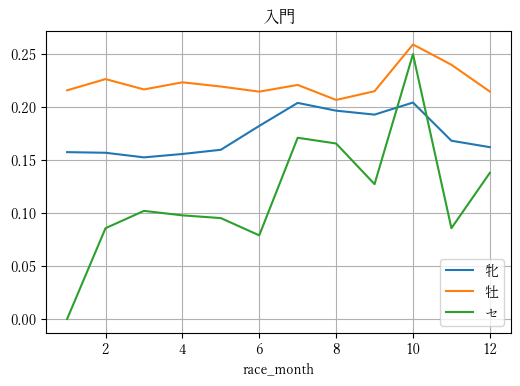

<Figure size 600x400 with 0 Axes>

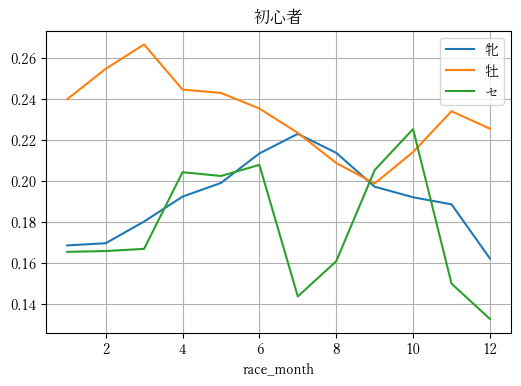

<Figure size 600x400 with 0 Axes>

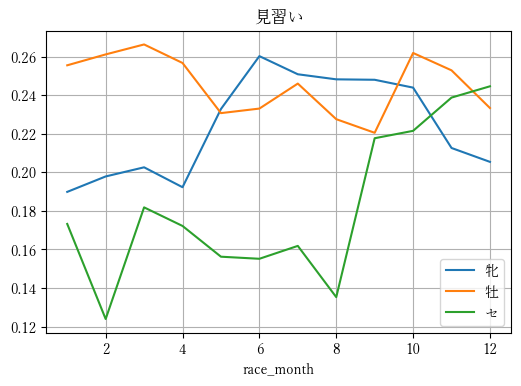

<Figure size 600x400 with 0 Axes>

In [12]:
for k,tmp in d.items():
    tmp.drop('All').plot(grid=True)
#     plt.plot([1,12], [0.22, 0.22], color='c')
#     plt.plot([1,12], [0.20, 0.20], color='c')
#     plt.plot([1,12], [0.18, 0.18], color='c')
    plt.title(k)
    plt.show()
    plt.clf()
    # plt.plot([1,12], [0.17, 0.17], color='c')

# add features

In [224]:
df_main2['age_ss'] = df_main2['age'].copy()
df_main2['abs_distance_diff'] = abs(df_main2['distance_diff'])
df_main2['last_got_prize_sum'] = df_main2['last_got_prize_sum'].fillna(0)
df_main2['last_got_prize_sum_rank'] = df_main2.groupby('race_id').last_got_prize_sum.rank(ascending=False, method='min')
df_main2['abs_weight_chenge_rate'] = abs(df_main2['weight_change_rate']-1)
df_main2['abs_weight_change_rate_rank'] = df_main2.groupby('race_id').abs_weight_chenge_rate.rank(method='min')
df_main2['last_uphill_rank'] = df_main2.groupby('race_id').last_uphill.rank(method='min')
df_main2['interval_days_diff'] = abs(df_main2.interval_days - 20)
df_main2['interval_days_diff_rank'] = df_main2.groupby('race_id').interval_days_diff.rank(method='max')

In [225]:
df_main2 = pd.get_dummies(df_main2, columns=['race_class_prize'])

KeyError: "None of [Index(['race_class_prize'], dtype='object')] are in the [columns]"

# scale features

In [38]:
df_main['age_ss'] = df_main['age'].copy()

In [60]:
df_main.isnull().sum() / df_main.shape[0]

arrival                        0.000000
race_id                        0.000000
horse_id                       0.000000
race_date                      0.000000
age                            0.000000
first_data_flg                 0.000000
last_weight_3_mean             0.240612
interval_days                  0.019745
last_turf_flg                  0.000000
distance_diff                  0.019745
last_weather_int               0.056475
last_condition_int             0.056475
is_first_in_prize              0.000000
last_arrival                   0.056475
p2_arrival                     0.431179
p3_arrival                     0.557622
last_speed                     0.056475
last_uphill                    0.056482
last_uphill_speed              0.056482
last_uphill_samecc             0.311110
same_cluster_flg               0.000000
is_same_place                  0.000000
last_got_prize                 0.624974
last_got_prize_sum             0.000000
course_num                     0.000000


In [39]:
df_use = scale_feature.scale_by_race_id(df_main, ss_col, mm_col, key_cols+not_z_col)

In [40]:
df_use['target'] = 0
df_use.loc[df_use.arrival<=TARGET_VALUE, 'target'] = 1

df_use.fillna(FILL_VALUE, inplace=True)
# df_train, df_test = split_data(df_use)
# y_test = df_test['target']

# s_rate = balance_target.get_srate(y_test)

In [42]:
df_use.shape

(130359, 51)

# train

In [43]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

In [44]:
df_train, df_test = train_test_split(df_use, stratify=df_use['target'], random_state=0)

In [45]:
X_cols = [
    'last_got_prize',
    'last_got_prize_sum',
    'last_got_prize_sum_rank',
    'last_arrival',
    'p2_arrival',
    'p3_arrival',
    'age_ss',
    'age',
    'course_num',
    'last_turf_flg',
    'weight',
    'last_weight_3_mean',
    'abs_weight_change_rate',
    'abs_weight_change_rate_rank',
    'handy_weight',
    'handy_rate',
    'interval_days',
    'interval_days_diff',
#     'race_month',
    'is_first_in_prize',
    'abs_distance_diff',
    'is_same_place',
    'same_cluster_flg',
    'last_speed',
    'last_uphill',
    'last_uphill_samecc',
    'last_uphill_speed',
    'last_uphill_rank',
#     'last_weather_int',
    'last_condition_int',
    'm_rate',
#     'gender_セ',
#     'gender_牝',
    'gender_牡',
    'place_地',
    'place_西',
#     'place_東',
    'race_class_prize_1勝クラス',
#     'race_class_prize_2勝クラス',
    'race_class_prize_3勝クラス',
    'race_class_prize_未勝利', 
]

In [46]:
X_train = df_train[X_cols]
y_train = df_train['target']
X_test = df_test[X_cols]
y_test = df_test['target']

## search

### GridSearch

### backward

In [112]:
# 変数減少法
train_x_data = X_train.copy()
train_y_data = y_train.copy()
test_x_data = X_test.copy()
test_y_data = y_test.copy()
 
col_names = train_x_data.columns.tolist()

model = XGBClassifier(
    scale_pos_weight=(len(y_train)-sum(y_train)) / sum(y_train),
    max_depth=3,
    gamma=10,
    subsample=0.8,
    random_state=0,
    eval_metric='logloss'
)


# 列名を減少させていくことで、入力データをヘンス指定で取得する
target_col_names = col_names.copy()
target_col_names = target_col_names[::-1]

base_score = -1       # 前ループの正答率
loop_max_score = 0    # 現ループの最大正答率
del_col_name = ''     # 削除変数

selected_col_names = []
scores = []

selected_k = 0
selected_score = 0

# 現ループの最大正答率が前ループより大きいかつ、選択できる変数があるならば続行
while (base_score < loop_max_score) and len(target_col_names) > 0:

    base_score = loop_max_score

    for target_col_name in target_col_names:
        col_names_ = target_col_names.copy()
        col_names_.remove(target_col_name)

        # 入力データから変数の選択
        train_x_data_ = train_x_data.loc[:, col_names_]
        test_x_data_ = test_x_data.loc[:, col_names_]

        model.fit(train_x_data_, train_y_data)
        pred = model.predict_proba(test_x_data_)[:, 1]
        score = roc_auc_score(test_y_data, pred)

        if score > loop_max_score:
            loop_max_score = score
            del_col_name = target_col_name

    if loop_max_score <= base_score:
        break

    if del_col_name in target_col_names:
        # 正答率を最も改善する変数を削除
        target_col_names.remove(del_col_name)
        selected_col_names.append(','.join(target_col_names))
        scores.append(loop_max_score)
        print('k {:3} : score {:5.2f}'.format(len(target_col_names), loop_max_score * 100), del_col_name)

print('')
print('[MAX SCORE] : k {} : score {}'.format(len(selected_col_names[int(np.argmax(scores))].split(',')),
                                              loop_max_score))
print(selected_col_names[int(np.argmax(scores))])


ks = [len(cols.split(',')) for cols in selected_col_names]
results = pd.DataFrame([ks,
                        scores,
                        selected_col_names]).T
results.columns = ['n_variable', 'score', 'selected_col_name']
results

k  44 : score 76.05
k  43 : score 76.07

[MAX SCORE] : k 43 : score 0.7606679178395495
race_class_prize_未勝利,race_class_prize_3勝クラス,race_class_prize_2勝クラス,race_class_prize_1勝クラス,last_uphill_rank,interval_days_diff,abs_weight_change_rate_rank,last_got_prize_sum_rank,age,race_month,course_num,last_condition_int,last_weather_int,last_turf_flg,is_first_in_prize,first_data_flg,place_西,place_東,place_地,place_なし,gender_牡,gender_牝,gender_セ,same_cluster_flg,is_same_place,weight_null_flg,p3_arrival,p2_arrival,last_arrival,m_rate,last_got_prize_sum,last_got_prize,last_weight_3_mean,last_uphill_samecc,last_uphill,last_uphill_speed,last_speed,abs_distance_diff,interval_days,age_ss,handy_weight,handy_rate,weight


,n_variable,score,selected_col_name
0,44,0.760518,"race_class_prize_未勝利,race_class_prize_3勝クラス,ra..."
1,43,0.760668,"race_class_prize_未勝利,race_class_prize_3勝クラス,ra..."


In [113]:
selected_col_names[int(np.argmax(scores))].split(',')

['race_class_prize_未勝利',
 'race_class_prize_3勝クラス',
 'race_class_prize_2勝クラス',
 'race_class_prize_1勝クラス',
 'last_uphill_rank',
 'interval_days_diff',
 'abs_weight_change_rate_rank',
 'last_got_prize_sum_rank',
 'age',
 'race_month',
 'course_num',
 'last_condition_int',
 'last_weather_int',
 'last_turf_flg',
 'is_first_in_prize',
 'first_data_flg',
 'place_西',
 'place_東',
 'place_地',
 'place_なし',
 'gender_牡',
 'gender_牝',
 'gender_セ',
 'same_cluster_flg',
 'is_same_place',
 'weight_null_flg',
 'p3_arrival',
 'p2_arrival',
 'last_arrival',
 'm_rate',
 'last_got_prize_sum',
 'last_got_prize',
 'last_weight_3_mean',
 'last_uphill_samecc',
 'last_uphill',
 'last_uphill_speed',
 'last_speed',
 'abs_distance_diff',
 'interval_days',
 'age_ss',
 'handy_weight',
 'handy_rate',
 'weight']

In [28]:
backward_cols = ['race_class_prize_未勝利',
 'race_class_prize_3勝クラス',
 'race_class_prize_2勝クラス',
 'race_class_prize_1勝クラス',
 'last_uphill_rank',
 'interval_days_diff',
 'abs_weight_change_rate_rank',
 'last_got_prize_sum_rank',
 'age',
 'race_month',
 'course_num',
 'last_condition_int',
 'last_weather_int',
 'last_turf_flg',
 'is_first_in_prize',
 'first_data_flg',
 'place_西',
 'place_東',
 'place_地',
 'place_なし',
 'gender_牡',
 'gender_牝',
 'gender_セ',
 'same_cluster_flg',
 'is_same_place',
 'weight_null_flg',
 'p3_arrival',
 'p2_arrival',
 'last_arrival',
 'm_rate',
 'last_got_prize_sum',
 'last_got_prize',
 'last_weight_3_mean',
 'last_uphill_samecc',
 'last_uphill',
 'last_uphill_speed',
 'last_speed',
 'abs_distance_diff',
 'interval_days',
 'age_ss',
 'handy_weight',
 'handy_rate',
 'weight']

In [29]:
set(backward_cols) - set(X_cols)

{'first_data_flg',
 'last_weather_int',
 'place_なし',
 'place_東',
 'weight_null_flg'}

### forward

In [115]:
train_x_data = X_train.copy()
train_y_data = y_train.copy()
test_x_data = X_test.copy()
test_y_data = y_test.copy()

col_names = train_x_data.columns.tolist()

model = XGBClassifier(
    scale_pos_weight=(len(y_train)-sum(y_train)) / sum(y_train),
    max_depth=3,
    gamma=10,
    subsample=0.8,
    random_state=0,
    eval_metric='logloss'
)

target_col_names = []              # 選択変数の格納
loop_col_names = col_names.copy()  # 未選択変数を格納

base_score = -1
loop_max_score = 0
additional_col_name = ''

selected_col_names = []
scores = []

selected_k = 0
selected_score = 0

# 現ループが前ループより正答率が高くかつ、未選択変数が残されているならば続行
while (base_score < loop_max_score) and len(loop_col_names) > 0:

    base_score = loop_max_score

    for target_col_name in loop_col_names:
        col_names_ = target_col_names.copy()
        col_names_.append(target_col_name)

        # 入力データから変数の選択
        train_x_data_ = train_x_data.loc[:, col_names_]
        test_x_data_ = test_x_data.loc[:, col_names_]

        model.fit(train_x_data_, train_y_data)
        pred = model.predict_proba(test_x_data_)[:, 1]
        score = roc_auc_score(test_y_data, pred)

        if score > loop_max_score:
            loop_max_score = score
            additional_col_name = target_col_name

    if base_score >= loop_max_score:
        break

    # 未選択変数群から選択分数を削除
    loop_col_names.remove(additional_col_name)
    target_col_names.append(additional_col_name)
    selected_col_names.append(','.join(target_col_names))
    scores.append(loop_max_score)
    print('k {:3} : score {:5.2f}%'.format(len(target_col_names), loop_max_score * 100), additional_col_name)

print('')
print('[MAX SCORE] : k {} : score {}%'.format(len(selected_col_names[int(np.argmax(scores))].split(',')),
                                              loop_max_score))
print(selected_col_names[int(np.argmax(scores))])


ks = [len(cols.split(',')) for cols in selected_col_names]
results = pd.DataFrame([ks,
                        scores,
                        selected_col_names]).T
results.columns = ['n_variable', 'score', 'selected_col_name']

# results.to_csv(output_dir_path.joinpath('forward_selection.tsv'),
#                sep='\t',
#                encoding='utf-8',
#                index=False)

k   1 : score 70.26%
k   2 : score 72.95%
k   3 : score 73.95%
k   4 : score 74.48%
k   5 : score 74.84%
k   6 : score 75.03%
k   7 : score 75.24%
k   8 : score 75.32%
k   9 : score 75.49%
k  10 : score 75.54%
k  11 : score 75.64%
k  12 : score 75.73%
k  13 : score 75.79%
k  14 : score 75.86%
k  15 : score 75.93%
k  16 : score 75.94%
k  17 : score 75.97%

[MAX SCORE] : k 17 : score 0.7597429761070901%
last_arrival,last_got_prize_sum_rank,age_ss,p2_arrival,last_uphill_rank,weight,interval_days_diff,p3_arrival,course_num,last_turf_flg,last_got_prize,abs_weight_change_rate_rank,race_month,place_東,age,is_first_in_prize,race_class_prize_1勝クラス


NameError: name 'output_dir_path' is not defined

In [116]:
selected_col_names[int(np.argmax(scores))].split(',')

['last_arrival',
 'last_got_prize_sum_rank',
 'age_ss',
 'p2_arrival',
 'last_uphill_rank',
 'weight',
 'interval_days_diff',
 'p3_arrival',
 'course_num',
 'last_turf_flg',
 'last_got_prize',
 'abs_weight_change_rate_rank',
 'race_month',
 'place_東',
 'age',
 'is_first_in_prize',
 'race_class_prize_1勝クラス']

In [117]:
forward_cols = ['last_arrival',
 'last_got_prize_sum_rank',
 'age_ss',
 'p2_arrival',
 'last_uphill_rank',
 'weight',
 'interval_days_diff',
 'p3_arrival',
 'course_num',
 'last_turf_flg',
 'last_got_prize',
 'abs_weight_change_rate_rank',
 'race_month',
 'place_東',
 'age',
 'is_first_in_prize',
 'race_class_prize_1勝クラス']

In [232]:
clf = XGBClassifier(
    scale_pos_weight=(len(y_train)-sum(y_train)) / sum(y_train),
    max_depth=3,
    gamma=10,
    subsample=0.8,
    random_state=0,
    eval_metric='logloss'
)

clf.fit(df_train[backward_cols], y_train)
pred = clf.predict_proba(df_test[backward_cols])[:, 1]
print(roc_auc_score(y_test, pred))

0.7576074688826107


In [ ]:
0.7564074137712897

## train

In [47]:
clf = XGBClassifier(
    scale_pos_weight=(len(y_train)-sum(y_train)) / sum(y_train),
    max_depth=3,
    gamma=10,
    subsample=0.8,
    random_state=0,
    eval_metric='logloss'
)

clf.fit(X_train, y_train)

pred = clf.predict_proba(X_test)[:, 1]
print(roc_auc_score(y_test, pred))

0.755335140384809


In [48]:
pd.DataFrame([clf.feature_importances_], columns=X_cols).T

,0
last_got_prize,0.335533
last_got_prize_sum,0.044478
last_got_prize_sum_rank,0.118656
last_arrival,0.059645
p2_arrival,0.039831
p3_arrival,0.021933
age_ss,0.034684
age,0.022922
course_num,0.017551
last_turf_flg,0.036377


## output

In [49]:
log_path = resource_path /'model_build/logs/wh/20201219'
os.makedirs(log_path/'image', exist_ok=True)

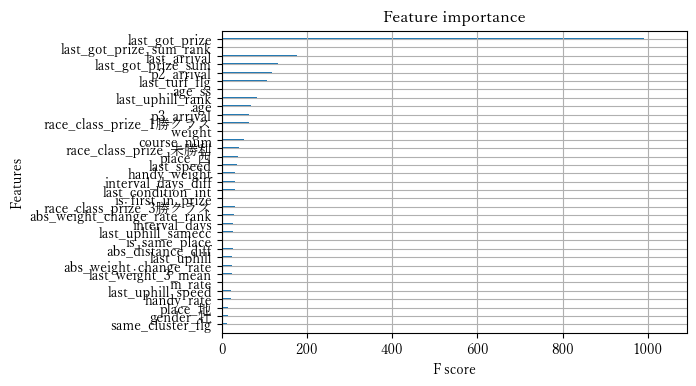

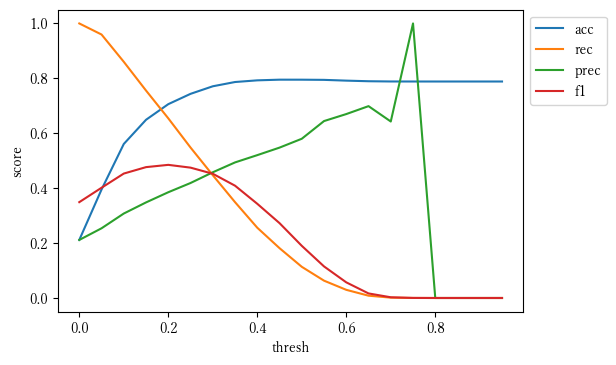

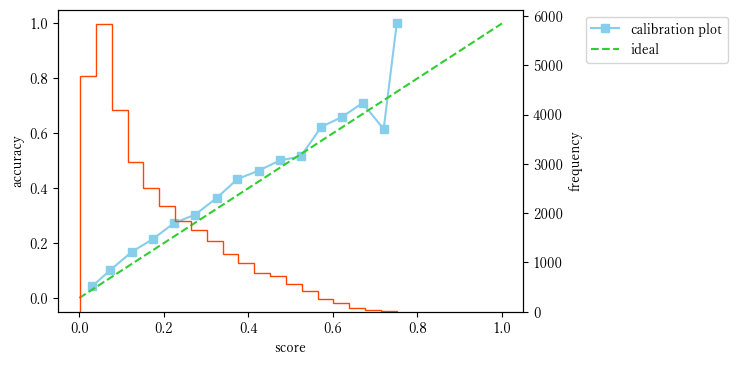

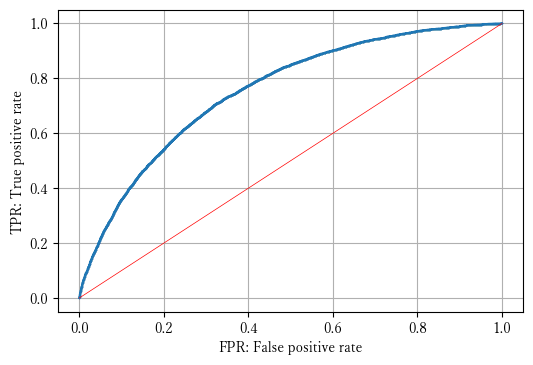

In [50]:
COMMENT = ''
s_rate = y_test.sum() / len(y_test)
prob2 = predict(clf, s_rate, df_test, df_use)
output_model(clf, y_test, prob2, s_rate)

In [51]:
prob3 = balance_target.adjusted_prob(clf.predict_proba(df_use[X_cols])[:, 1], s_rate)

In [54]:
df_use['pred_prob'] = prob3

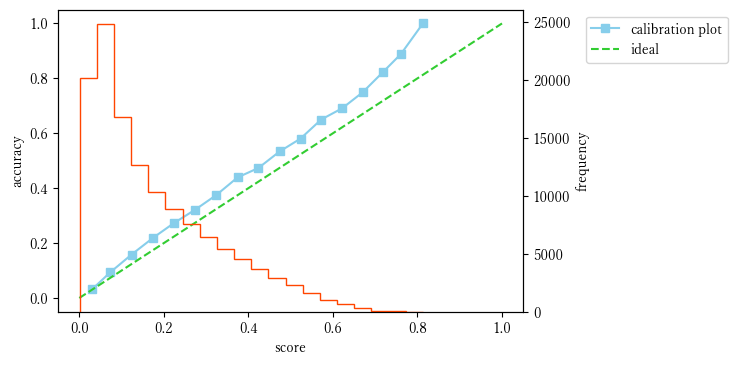

In [55]:
plot_calibration(df_use.target, prob3)

In [56]:
roc_auc_score(df_use.target, prob3)

0.7747254842991675

# check acc_rate

In [46]:
df_pred = df_use[['arrival', 'race_id', 'horse_id', 'pred_prob']].copy()
df_pred['pred_rank'] = df_pred.groupby('race_id').pred_prob.rank(ascending=False, method='min')

In [47]:
df_ac = pd.DataFrame(index=df_pred.race_id.unique())
df_ac.index.name = 'race_id'
tmp = df_pred.loc[(df_pred.pred_rank<=5)&(df_pred.arrival<=3)].race_id.value_counts()
df_ac['三連複'] = 0
df_ac.loc[df_ac.index.isin(tmp.loc[tmp>=3].index), '三連複'] = 1

In [48]:
tmp = df_pred.loc[(df_pred.pred_rank<=3)&(df_pred.arrival<=3)].race_id.value_counts()
df_ac['三連複_123'] = 0
df_ac.loc[df_ac.index.isin(tmp.loc[tmp==3].index), '三連複_123'] = 1

In [49]:
df_ac = df_ac.merge(df_info[['race_class_prize', 'race_date']], how='left', left_index=True, right_index=True)

In [50]:
df_ac.三連複.sum() / df_ac.shape[0]

0.2714394682358069

In [51]:
tmp = pd.crosstab(df_ac.race_class_prize, df_ac.三連複, margins=True)
tmp['rate'] = tmp[1] / tmp.All
tmp

三連複,0,1,All,rate
race_class_prize,,,,
1勝クラス,2464,792,3256,0.243243
2勝クラス,1202,460,1662,0.276775
3勝クラス,550,179,729,0.245542
未勝利,2470,1060,3530,0.300283
All,6686,2491,9177,0.271439


In [52]:
tmp = pd.crosstab(df_ac.race_class_prize, df_ac.三連複_123, margins=True)
tmp['rate'] = tmp[1] / tmp.All
tmp

三連複_123,0,1,All,rate
race_class_prize,,,,
1勝クラス,3092,164,3256,0.050369
2勝クラス,1564,98,1662,0.058965
3勝クラス,691,38,729,0.052126
未勝利,3297,233,3530,0.066006
All,8644,533,9177,0.058080


In [53]:
df_ac['year'] = df_ac.race_date.dt.year
tmp = pd.crosstab(df_ac.year, df_ac.三連複, margins=True)
tmp['rate'] = tmp[1] / tmp.All
tmp

三連複,0,1,All,rate
year,,,,
2012,531,209,740,0.282432
2013,899,288,1187,0.242628
2014,894,299,1193,0.250629
2015,901,315,1216,0.259046
2016,909,315,1224,0.257353
2017,877,327,1204,0.271595
2018,846,371,1217,0.304848
2019,829,367,1196,0.306856
All,6686,2491,9177,0.271439


In [192]:
AUC = roc_auc_score(y_test, prob2)